In [1]:
from global_vars import *
from commons import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os
from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
import matplotlib.pyplot as plt

# is_cords_finalized = True

%load_ext autoreload
%autoreload 2

In [2]:
def add_all_labels(paths):
    affine = None
    data = np.zeros((256,256,400))
    for idx, path in enumerate(paths):
        print(path)
        img = nb.load(path)
        if affine is None:
            affine = img.affine
        img_data= img.get_fdata()
        x,y,z = img.shape
        data[:x, :y, :z] += img_data
        
    empty_header = nibabel.Nifti1Header()
    all_label_img = nb.Nifti1Image(data, affine, empty_header)
    return all_label_img

def resize(img, shape=(256, 256, 400), is_label=False):
    if is_label:
        order = 0
    else:
        order = 3
    mode='constant'
    print(img.shape)
    img = resample_from_to(img, [shape, img.affine], order=order, mode=mode, cval=0)
    return img

def crop(paths, shape):
    s1, e1, s2, e2, s3, e3 = shape
    for path in paths:
        img = nb.load(path)
        img_data= img.get_fdata()
        data = img_data[s1:e1, s2:e2, s3:e3]
        img = nb.Nifti1Image(data, img.affine, img.header)
        save_path = '/'.join(path.split('/')[:-1])
        vol_id = path.split('/')[-1].split('.')[0]
        save_volume(img, f'{save_path}_cropped/{vol_id}')

def remove_black(labelmap):
    clean_labels = []
    start, end = None, None
    start_2, end_2 = None, None
    for i, frame in enumerate(labelmap):
        unique, counts = np.unique(frame, return_counts=True)
        if counts[0] / sum(counts) < .99:
            clean_labels.append(frame)
            if start is None:
                start = i
            elif start_2 is None:
                start_2 = i
            if end is not None:
                end_2 = end
            end = None
        if end is None:
            end = i
    if end is None:
        end = labelmap.shape[0]
            
    return np.array(clean_labels), start, end, start_2, end_2

In [3]:
processed_dir = 'temp2/KORA/processed'
kora_labels = glob.glob(f'{processed_dir}/label/**')
kora_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp2/NAKO/processed'
nako_labels = glob.glob(f'{processed_dir}/label/**')
nako_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp2/UKB/processed'
ukb_labels = glob.glob(f'{processed_dir}/label/**')
ukb_volumes = glob.glob(f'{processed_dir}/volume/**')

all_labels = kora_labels + nako_labels + ukb_labels
all_volumes = kora_volumes + nako_volumes + ukb_volumes

print(all_labels, all_volumes)
# print(kora_volumes, kora_labels)

['temp2/KORA/processed/label/KORA2453578.nii.gz', 'temp2/KORA/processed/label/KORA2459908.nii.gz', 'temp2/KORA/processed/label/KORA2462405.nii.gz', 'temp2/KORA/processed/label/KORA2458366.nii.gz', 'temp2/KORA/processed/label/KORA2456289.nii.gz', 'temp2/KORA/processed/label/KORA2453666.nii.gz', 'temp2/KORA/processed/label/KORA2452879.nii.gz', 'temp2/KORA/processed/label/KORA2459745.nii.gz', 'temp2/KORA/processed/label/KORA2460734.nii.gz', 'temp2/KORA/processed/label/KORA2460408.nii.gz', 'temp2/KORA/processed/label/KORA2453229.nii.gz', 'temp2/KORA/processed/label/KORA2453290.nii.gz', 'temp2/KORA/processed/label/KORA2456120.nii.gz', 'temp2/KORA/processed/label/KORA2460723.nii.gz', 'temp2/KORA/processed/label/KORA2460830.nii.gz', 'temp2/KORA/processed/label/KORA2462026.nii.gz', 'temp2/KORA/processed/label/KORA2459728.nii.gz', 'temp2/KORA/processed/label/KORA2453363.nii.gz', 'temp2/NAKO/processed/label/100017.nii.gz', 'temp2/NAKO/processed/label/100025.nii.gz', 'temp2/NAKO/processed/label/1

In [4]:
for vol in all_volumes:
    print(vol)
    vol_id = vol.split('/')[-1].split('.')[0]
    save_path = '/'.join(vol.split('/')[:-2])
    print(vol_id, save_path)
    vol_img = nb.load(vol)
    resized_img = resize(vol_img)
    save_volume(resized_img, f'{save_path}_resized/volume/{vol_id}')

temp2/KORA/processed/volume/KORA2453578.nii.gz
KORA2453578 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/processed_resized/volume
temp2/KORA/processed/volume/KORA2459908.nii.gz
KORA2459908 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/processed_resized/volume
temp2/KORA/processed/volume/KORA2462405.nii.gz
KORA2462405 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/processed_resized/volume
temp2/KORA/processed/volume/KORA2458366.nii.gz
KORA2458366 temp2/KORA/processed
(246, 150, 239)
saving directory: temp2/KORA/processed_resized/volume
temp2/KORA/processed/volume/KORA2456289.nii.gz
KORA2456289 temp2/KORA/processed
(246, 150, 239)
saving directory: temp2/KORA/processed_resized/volume
temp2/KORA/processed/volume/KORA2453666.nii.gz
KORA2453666 temp2/KORA/processed
(246, 150, 239)
saving directory: temp2/KORA/processed_resized/volume
temp2/KORA/processed/volume/KORA2452879.nii.gz
KORA2452879 temp2/KORA/processed
(246, 137, 239)
savi

temp2/UKB/processed/volume/1013391_20201_2_0.nii.gz
1013391_20201_2_0 temp2/UKB/processed
(250, 195, 178)
saving directory: temp2/UKB/processed_resized/volume
temp2/UKB/processed/volume/5397022_20201_2_0.nii.gz
5397022_20201_2_0 temp2/UKB/processed
(250, 195, 178)
saving directory: temp2/UKB/processed_resized/volume
temp2/UKB/processed/volume/5833278_20201_2_0.nii.gz
5833278_20201_2_0 temp2/UKB/processed
(250, 195, 178)
saving directory: temp2/UKB/processed_resized/volume
temp2/UKB/processed/volume/1036900_20201_2_0.nii.gz
1036900_20201_2_0 temp2/UKB/processed
(250, 195, 178)
saving directory: temp2/UKB/processed_resized/volume


In [5]:
for vol in all_labels:
    vol_id = vol.split('/')[-1].split('.')[0]
    save_path = '/'.join(vol.split('/')[:-2])
    print(vol_id, save_path)
    vol_img = nb.load(vol)
    resized_img = resize(vol_img, is_label=True)
    save_volume(resized_img, f'{save_path}_resized/label/{vol_id}')

KORA2453578 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2459908 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2462405 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2458366 temp2/KORA/processed
(246, 150, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2456289 temp2/KORA/processed
(246, 150, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2453666 temp2/KORA/processed
(246, 150, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2452879 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2459745 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2460734 temp2/KORA/processed
(246, 150, 239)
saving directory: temp2/KORA/processed_resized/label
KORA2460408 temp2/KORA/processed
(246, 137, 239)
saving directory: temp2/KORA/proc

In [6]:
processed_resized_dir = 'temp2/KORA/processed_resized'
kora_labels = glob.glob(f'{processed_resized_dir}/label/**')
kora_volumes = glob.glob(f'{processed_resized_dir}/volume/**')
processed_resized_dir = 'temp2/NAKO/processed_resized'
nako_labels = glob.glob(f'{processed_resized_dir}/label/**')
nako_volumes = glob.glob(f'{processed_resized_dir}/volume/**')
processed_resized_dir = 'temp2/UKB/processed_resized'
ukb_labels = glob.glob(f'{processed_resized_dir}/label/**')
ukb_volumes = glob.glob(f'{processed_resized_dir}/volume/**')

In [7]:
# kls = add_all_labels(kora_labels)
# volume_3_view_viewer(get_volume_data(kls))
# save_volume(kls, f'all_labels_merged/all_kora_labels')

# kls = add_all_labels(nako_labels)
# volume_3_view_viewer(get_volume_data(kls))
# save_volume(kls, f'all_labels_merged/all_nako_labels')

# kls = add_all_labels(ukb_labels)
# volume_3_view_viewer(get_volume_data(kls))
# save_volume(kls, f'all_labels_merged/all_ukb_labels')

In [8]:
# img = nb.load(f'all_labels_merged/all_kora_labels.nii.gz')
# img_data = img.get_fdata()
# img_d1, s1,e1, s12, e12 = remove_black(img_data)
# img_data1 = np.moveaxis(img_data, 1, 0)
# img_d2, s2,e2, s22, e22 = remove_black(img_data1)
# img_data2 = np.moveaxis(img_data, 2, 0)
# img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# # img_data = np.moveaxis(img_data, axis=0)

# print('kora', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1,s2,e2,s3,e3,'---', s12,e12,s22,e22,s32,e32)

# img = nb.load(f'all_labels_merged/all_nako_labels.nii.gz')
# img_data = img.get_fdata()
# img_d1,s1,e1, s12, e12 = remove_black(img_data)
# img_data1 = np.moveaxis(img_data, 1, 0)
# img_d2,s2,e2, s22, e22 = remove_black(img_data1)
# img_data2 = np.moveaxis(img_data, 2, 0)
# img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# # img_data = np.moveaxis(img_data, axis=0)

# print('nako', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1,s2,e2,s3,e3,'---', s12,e12,s22,e22,s32,e32)

# img = nb.load(f'all_labels_merged/all_ukb_labels.nii.gz')
# img_data = img.get_fdata()
# img_d1,s1,e1, s12, e12 = remove_black(img_data)
# img_data1 = np.moveaxis(img_data, 1, 0)
# img_d2,s2,e2, s22, e22 = remove_black(img_data1)
# img_data2 = np.moveaxis(img_data, 2, 0)
# img_d3,s3,e3, s32, e32 = remove_black(img_data2)
# # img_data = np.moveaxis(img_data, axis=0)

# print('ukb', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1, s2,e2, s3,e3,'---', s12,e12,s22,e22,s32,e32)

In [9]:
# KORA = 158,100,91   ---  49, 206, 23, 122, 84, 176  --> 40, 210, 5, 145, 80, 180 == 170, 140, 100  == 176, 144, 112/96  (Multiples of 16)
#                                                       "40, 215, 5, 175, 70, 180" == "175, 170, 110" ==  '192 176 112'== 32, 224, 2, 178, 69, 181
# NAKO = 158,104,76    --- 44, 201, 40, 143, 169, 244  --> 41, 201, 23, 143, 169, 244 == 160, 120, 75 == 160, 128, 84 =AFTER FAT TALL MATCH= 
#                                                       31, 201, 23, 143, 160, 265 == "170, 120, 105" == '192 176 112' == 20, 212, 0, 176, 157, 269
# UKB= 163, 117, 97    --- 47, 209, 42, 158, 80, 176  --> 35, 215, 25, 170, 215, 315 == 180,145, 100 == 176/192, 144/160, 112 =AFTER FAT TALL[Missing] MATCH= 
#            (Evaluated on 6 merged UKB scans. BH+NOBH) 35, 215, 25, 170, 210, 315 == "180, 145, 105" == '192 176 112' == 29, 221, 10, 186, 72, 184  (for BH Merge only)
 
# KORA sample vol size = 250, 188, 370
# NAKO sample vol size = 226,184,316
# UKB sample vol size = 246, 137, 239
# sample target shape = 256, 256,400

In [10]:
crop(kora_volumes, [32, 224, 2, 178, 69, 181])

saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving directory: temp2/KORA/processed_resized/volume_cropped
saving d

In [11]:
crop(kora_labels, [32, 224, 2, 178, 69, 181])

saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/KORA/processed_resized/label_cropped
saving directory: temp2/

In [12]:
crop(nako_volumes, [20, 212, 0, 176, 157, 269])

saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving directory: temp2/NAKO/processed_resized/volume_cropped
saving d

In [13]:
crop(nako_labels, [20, 212, 0, 176, 157, 269])

saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/NAKO/processed_resized/label_cropped
saving directory: temp2/

In [14]:
crop(ukb_volumes, [29, 221, 10, 186, 72, 184])

saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/UKB/processed_resized/volume_cropped
saving directory: temp2/

In [15]:
crop(ukb_labels, [29, 221, 10, 186, 72, 184])

saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_resized/label_cropped
saving directory: temp2/UKB/processed_re

In [16]:
processed_dir = 'temp2/KORA/processed_resized'
kora_labels_c = sorted(glob.glob(f'{processed_dir}/label_cropped/**'))
kora_volumes_c = sorted(glob.glob(f'{processed_dir}/volume_cropped/**'))
processed_dir = 'temp2/NAKO/processed_resized'
nako_labels_c = sorted(glob.glob(f'{processed_dir}/label_cropped/**'))
nako_volumes_c = sorted(glob.glob(f'{processed_dir}/volume_cropped/**'))
processed_dir = 'temp2/UKB/processed_resized'
ukb_labels_c = sorted(glob.glob(f'{processed_dir}/label_cropped/**'))
ukb_volumes_c = sorted(glob.glob(f'{processed_dir}/volume_cropped/**'))

In [17]:
all_c = kora_labels_c+nako_labels_c+ukb_labels_c
all_v = kora_volumes_c+nako_volumes_c+ukb_volumes_c
all_v

['temp2/KORA/processed_resized/volume_cropped/KORA2452879.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2453229.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2453290.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2453363.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2453578.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2453666.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2456120.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2456289.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2458366.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2459728.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2459745.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2459908.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2460408.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2460723.nii.gz',
 'temp2/KORA/processed_resized/volume_cropped/KORA2460734.nii.

KORA2452879 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


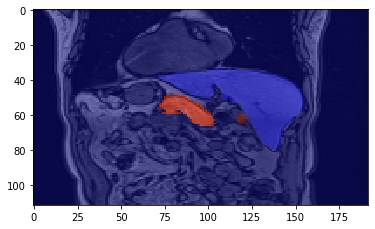

KORA2453229 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


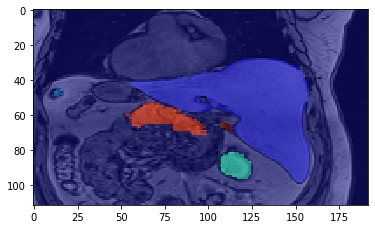

KORA2453290 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


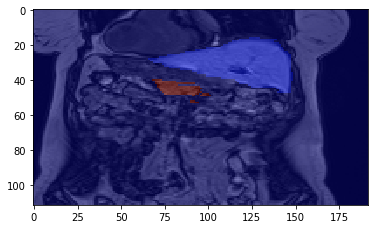

KORA2453363 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


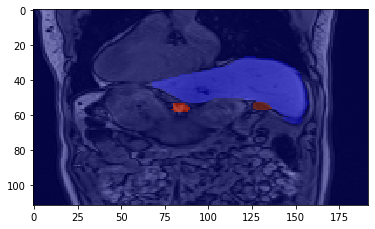

KORA2453578 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


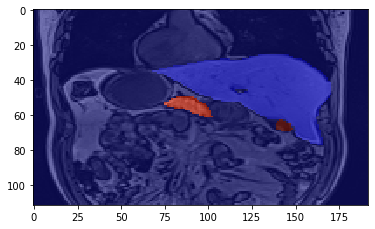

KORA2453666 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


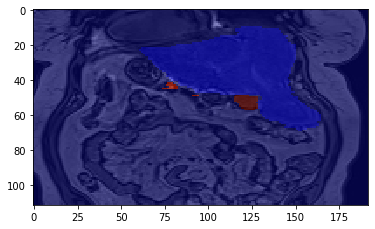

KORA2456120 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


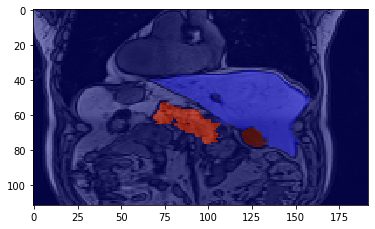

KORA2456289 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


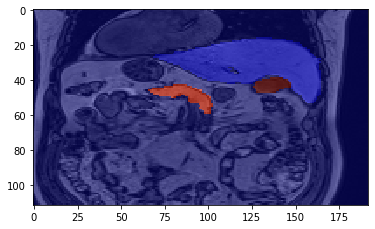

KORA2458366 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


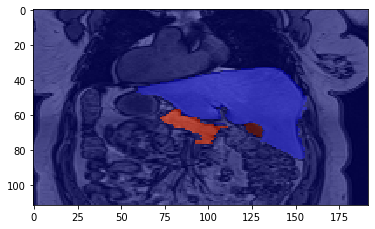

KORA2459728 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


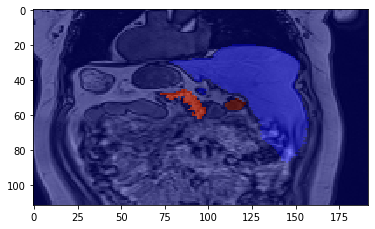

KORA2459745 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


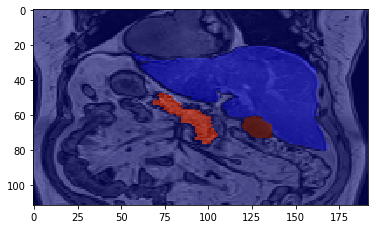

KORA2459908 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


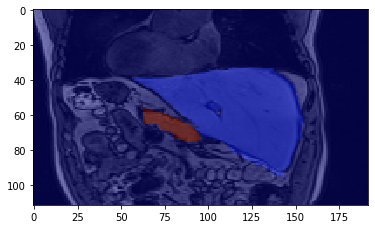

KORA2460408 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


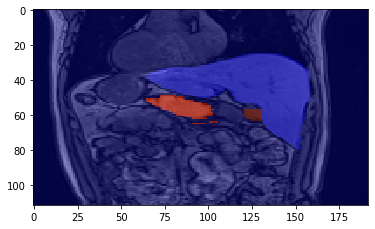

KORA2460723 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


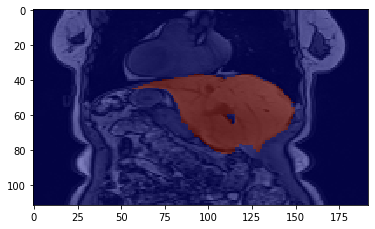

KORA2460734 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


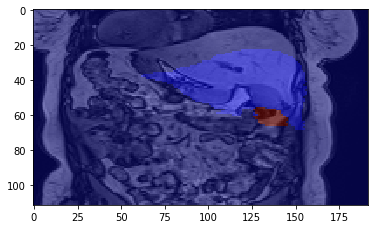

KORA2460830 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


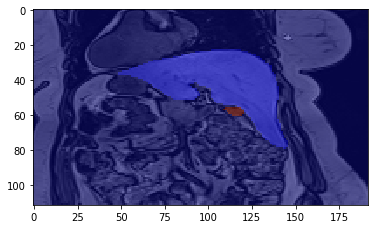

KORA2462026 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


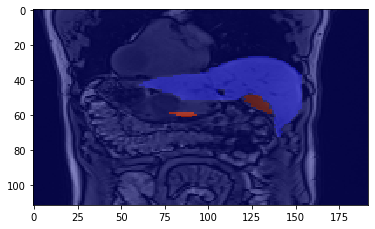

KORA2462405 temp2/KORA/processed_resized/volume_cropped temp2/KORA/processed_resized/label_cropped temp2/KORA/merged_imgs


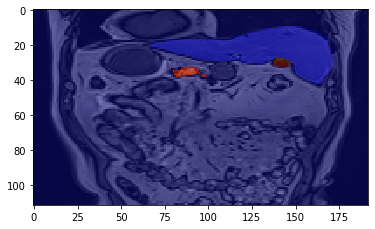

100008 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


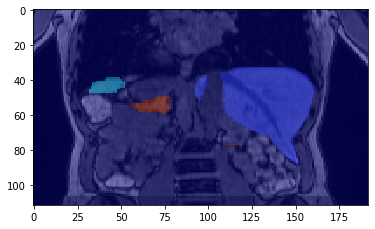

100009 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


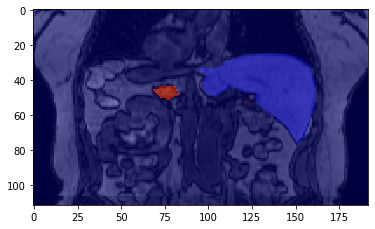

100013 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


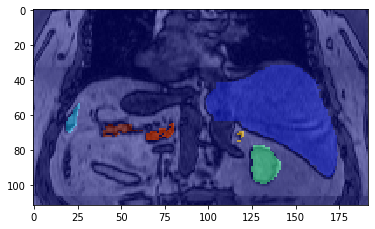

100017 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


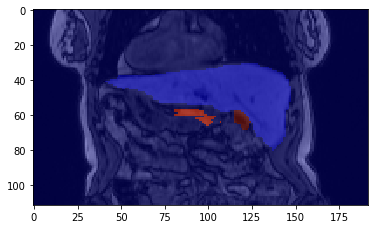

100020 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


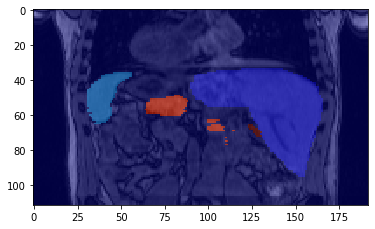

100025 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


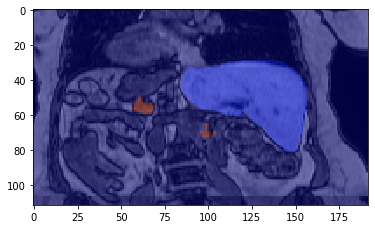

100035 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


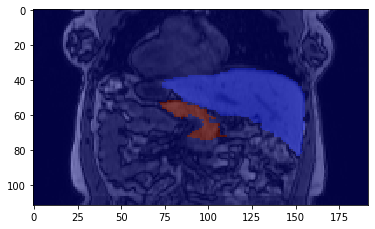

100083 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


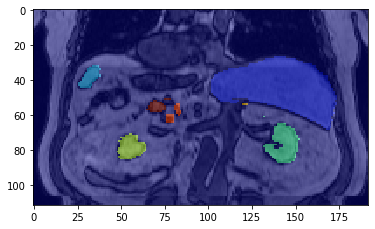

100085 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


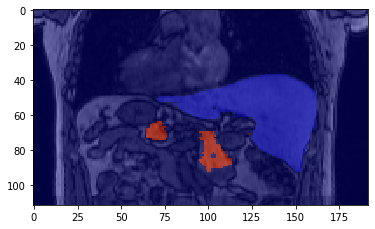

100094 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


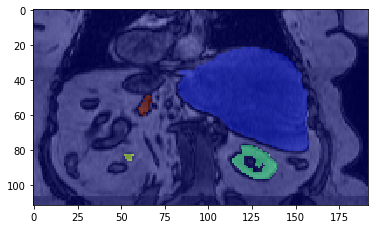

100097 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


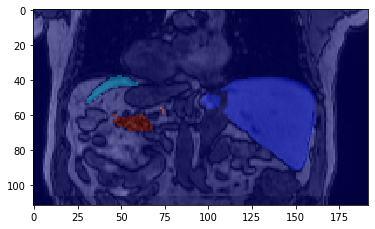

100112 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


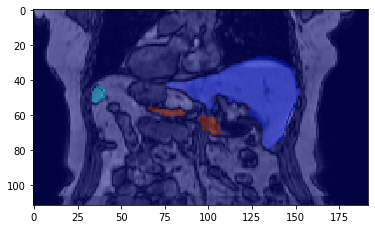

100116 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


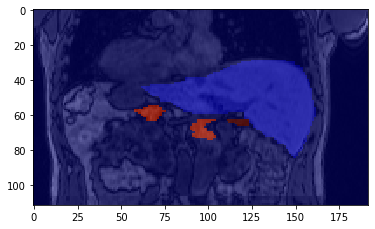

100129 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


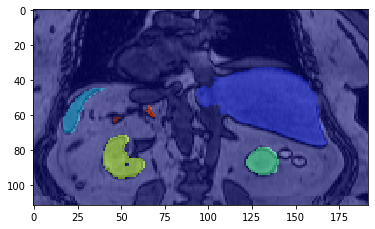

100142 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


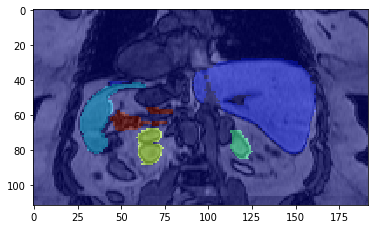

100161 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


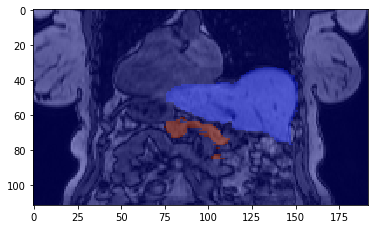

100181 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


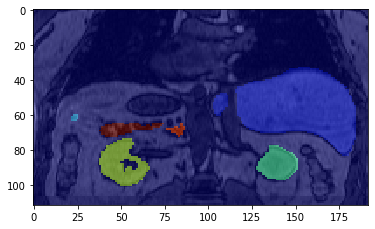

100183 temp2/NAKO/processed_resized/volume_cropped temp2/NAKO/processed_resized/label_cropped temp2/NAKO/merged_imgs


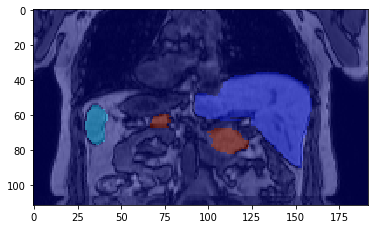

1002359_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


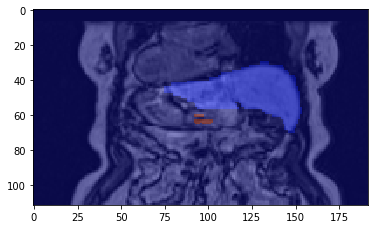

1003082_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


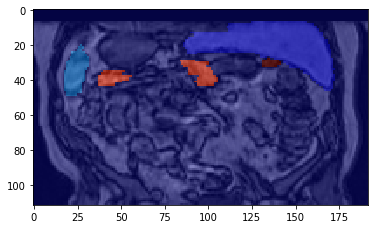

1005379_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


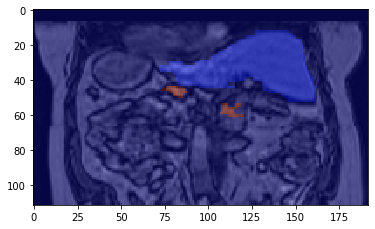

1013250_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


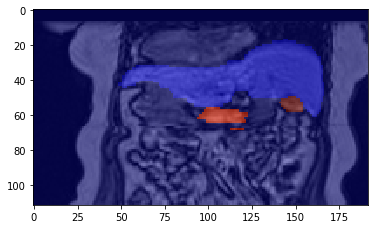

1013391_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


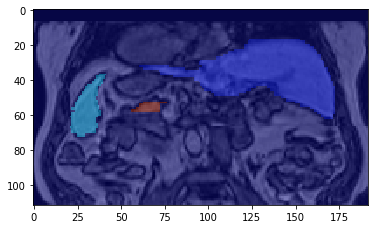

1019631_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


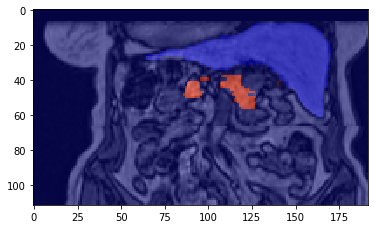

1026125_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


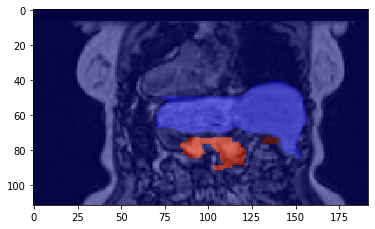

1036900_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


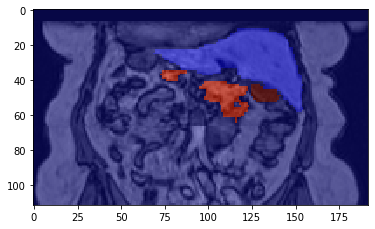

1108214_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


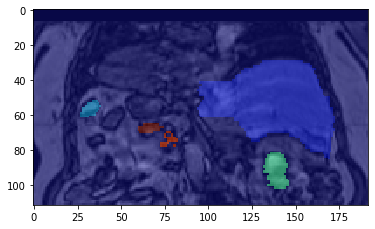

1138634_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


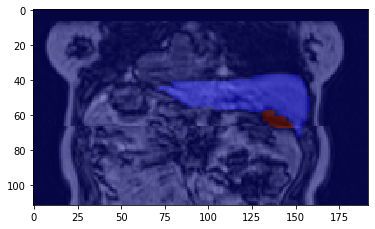

1584559_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


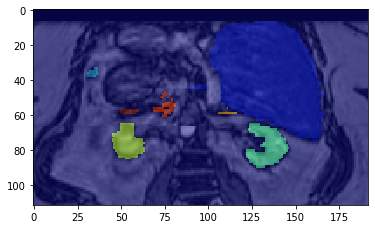

1883132_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


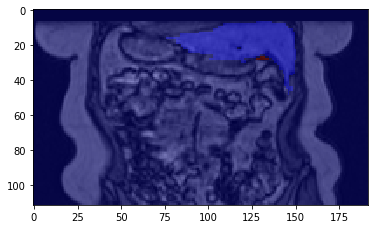

1942395_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


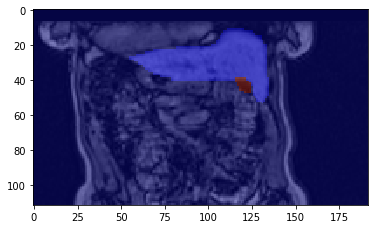

3387088_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


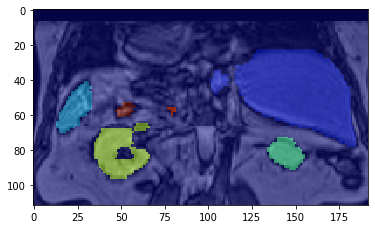

4154467_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


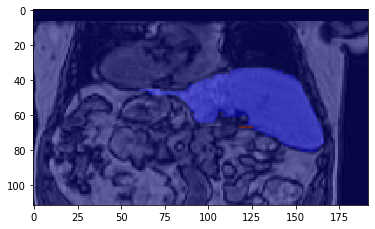

4627690_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


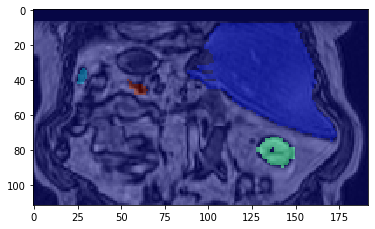

5331775_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


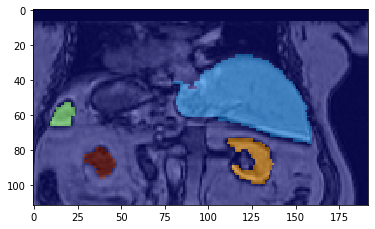

5371767_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


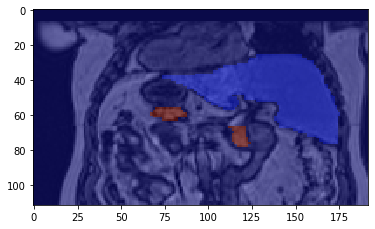

5397022_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


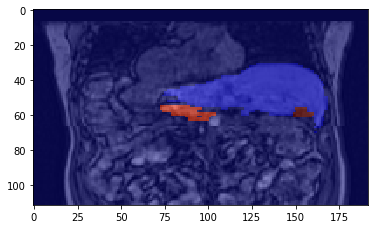

5764643_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


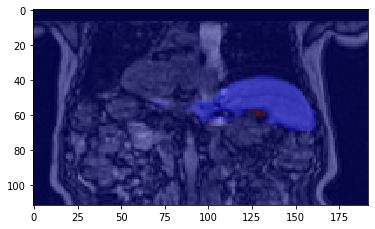

5833278_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


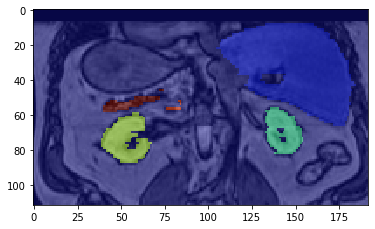

5934622_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


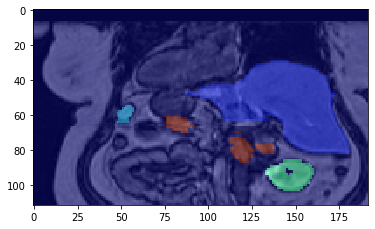

6025746_20201_2_0 temp2/UKB/processed_resized/volume_cropped temp2/UKB/processed_resized/label_cropped temp2/UKB/merged_imgs


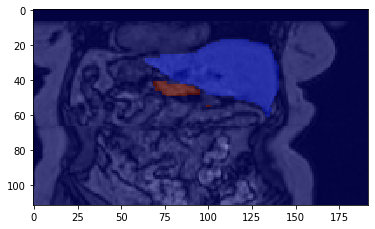

In [18]:
for p in all_c:
    volid = p.split('/')[-1].split('.')[0]
    vol_root= '/'.join(p.split('/')[:-2])+'/volume_cropped'
    label_root=  '/'.join(p.split('/')[:-2])+'/label_cropped'
    img_save_path= '/'.join(p.split('/')[:-3])+'/merged_imgs'
    print(volid, vol_root, label_root, img_save_path)
    create_if_not(img_save_path)
    visualize_and_save(volid, vol_root, label_root, img_save_path)

In [19]:
# NAKO_REFRENCE_IMAGE = '100083 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs'
# KORA_REFERENCE_IMAGE = 'KORA2459745 temp/KORA/processed_resized/volume_cropped temp/KORA/processed_resized/label_cropped temp/KORA/merged_imgs'
# UKB_REFERENCE_IMAGE= '5934622_20201_2_0 temp/UKB/processed_resized/volume_cropped temp/UKB/processed_resized/label_cropped temp/UKB/merged_imgs'
# ALL_REFERENCE_IMAGE='100083 temp/NAKO/processed_resized/volume_cropped temp/NAKO/processed_resized/label_cropped temp/NAKO/merged_imgs'

In [20]:
def estimate_weights_mfb(labels, no_of_class=9):
    class_weights = np.zeros_like(labels)
    unique, counts = np.unique(labels, return_counts=True)
    median_freq = np.median(counts)
    weights = np.zeros(no_of_class)
    for i, label in enumerate(unique):
        class_weights += (median_freq // counts[i]) * np.array(labels == label)
        weights[int(label)] = median_freq // counts[i]

    grads = np.gradient(labels)
    edge_weights = (grads[0] ** 2 + grads[1] ** 2) > 0
    class_weights += 2 * edge_weights

    return class_weights, weights

def estimate_weights_per_slice(labels, no_of_class=9):
    weights_per_slice = []
    for slice_ in labels:
        unique, counts = np.unique(slice_, return_counts=True)
        median_freq = np.median(counts)
        weights = np.zeros(no_of_class)
        for i, label in enumerate(unique):
            weights[int(label)] = median_freq // counts[i]
        weights_per_slice.append(weights)

    return np.array(weights_per_slice)

def min_max_norm(img):
#     return img
    volume = img.get_fdata()
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    return nb.Nifti1Image(volume, img.affine, img.header)
     

In [ ]:
# kora_test = ['KORA2456289', 'KORA2458366', 'KORA2459728', 'KORA2459745']
# nako_test = ['100025', '100035', '100085','100083']
# ukb_test = ['1019631_20201_2_0','1013391_20201_2_0','1108214_20201_2_0','1026125_20201_2_0','1036900_20201_2_0']

kora_test_text = '/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/kora/test.txt'
nako_test_text = '/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/nako/test.txt'
ukb_test_text = '/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/ukb/test.txt'

data_path = '/mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2'
all_test = []

all_test_paths = [kora_test_text, nako_test_text, ukb_test_text]
for volumes_txt_file in all_test_paths:
    with open(volumes_txt_file) as file_handle:
        volumes_to_use = file_handle.read().splitlines()
        print(volumes_txt_file, volumes_to_use)
        all_test.extend(volumes_to_use)

print(all_test)
exclude_list = ['KORA2460249', '100006', '1004985_20201_2_0', 'KORA2460734', 'volume']
# all_test = kora_test + nako_test + ukb_test
for p in all_v:
    ds = p.split('/')[1]
    vol_id = p.split('/')[-1].split('.')[0]
    print(vol_id)
    if vol_id in exclude_list:
        print('excluded:', vol_id)
        continue
    if vol_id == 'volume':
        continue
    
    new_path = '/'.join(p.split('/')[:2])
    
    reference_path = None
    all_reference_path = 'temp2/NAKO/processed_resized/volume_cropped/100085.nii.gz'
    if ds == 'KORA':
        reference_path = 'temp2/KORA/processed_resized/volume_cropped/KORA2459745.nii.gz'
    elif ds == 'NAKO':
        reference_path = 'temp2/NAKO/processed_resized/volume_cropped/100085.nii.gz'
    elif ds == 'UKB':
        reference_path = 'temp2/UKB/processed_resized/volume_cropped/5934622_20201_2_0.nii.gz'
    else:
        raise Exception('Unknown DS ')
    
    if reference_path == None:
        raise Exception('REFERENCE IS NONE')
    img = nb.load(p)
    print(p)
    label_img = nb.load(f'{new_path}/processed_resized/label_cropped/{vol_id}.nii.gz')
    label_data = label_img.get_fdata()
    label_class_weights, _  = estimate_weights_mfb(label_data)
    label_weights = estimate_weights_per_slice(label_data)
    print(label_class_weights.shape, label_weights.shape)
        
    if vol_id in all_test:
        phase = 'test'
    else:
        phase = 'train'
    
    new_path = f'{data_path}/{ds}'
    
    save_volume(img, f'{new_path}/{phase}/volume/{vol_id}')
    save_volume(min_max_norm(img), f'{new_path}/{phase}/volume_minmax/{vol_id}')
    
    save_volume(label_img, f'{new_path}/{phase}/label/{vol_id}')
    create_if_not(f'{new_path}/{phase}/label_class_weights')
    create_if_not(f'{new_path}/{phase}/label_weights')
    np.save(f'{new_path}/{phase}/label_class_weights/{vol_id}.npy', label_class_weights)
    np.save(f'{new_path}/{phase}/label_weights/{vol_id}.npy', label_weights)
    
    hist_matched_img = hist_match(img, reference_path)
    save_volume(hist_matched_img, f'{new_path}/{phase}/volume_hist/{vol_id}')
    save_volume(min_max_norm(hist_matched_img), f'{new_path}/{phase}/volume_hist_minmax/{vol_id}')
    intensity_matched_img = intensity_matching(img, reference_path)
    save_volume(intensity_matched_img, f'{new_path}/{phase}/volume_intensity/{vol_id}')
    save_volume(min_max_norm(intensity_matched_img), f'{new_path}/{phase}/volume_intensity_minmax/{vol_id}')
    
    all_path = f'{data_path}/ALL'
    save_volume(img, f'{all_path}/{phase}/volume/{vol_id}')
    save_volume(min_max_norm(img), f'{all_path}/{phase}/volume_minmax/{vol_id}')
    
    save_volume(label_img, f'{all_path}/{phase}/label/{vol_id}')
    create_if_not(f'{all_path}/{phase}/label_class_weights')
    create_if_not(f'{all_path}/{phase}/label_weights')
    np.save(f'{all_path}/{phase}/label_class_weights/{vol_id}.npy', label_class_weights)
    np.save(f'{all_path}/{phase}/label_weights/{vol_id}.npy', label_weights)
    
    hist_matched_img_all = hist_match(img, all_reference_path)
    save_volume(hist_matched_img_all, f'{all_path}/{phase}/volume_hist/{vol_id}')
    save_volume(min_max_norm(hist_matched_img_all), f'{all_path}/{phase}/volume_hist_minmax/{vol_id}')
    intensity_matched_img_all = intensity_matching(img, all_reference_path)
    save_volume(intensity_matched_img_all, f'{all_path}/{phase}/volume_intensity/{vol_id}')
    save_volume(min_max_norm(intensity_matched_img_all), f'{all_path}/{phase}/volume_intensity_minmax/{vol_id}')
    

/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/kora/test.txt ['KORA2453290', 'KORA2453666', 'KORA2460408']
/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/nako/test.txt ['100025', '100035', '100085', '100083']
/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/ukb/test.txt ['1019631_20201_2_0', '1013391_20201_2_0', '1108214_20201_2_0', '1026125_20201_2_0', '1036900_20201_2_0']
['KORA2453290', 'KORA2453666', 'KORA2460408', '100025', '100035', '100085', '100083', '1019631_20201_2_0', '1013391_20201_2_0', '1108214_20201_2_0', '1026125_20201_2_0', '1036900_20201_2_0']
KORA2452879
temp2/KORA/processed_resized/volume_cropped/KORA2452879.nii.gz
(192, 176, 112) (192, 9)
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_minmax
saving dire

saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_hist_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_intensity
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_intensity_minmax
KORA2453666
temp2/KORA/processed_resized/volume_cropped/KORA2453666.nii.gz
(192, 176, 112) (192, 9)
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/test/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/test/volume_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/test/label
Initiating histogram match...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/test/volume_hist
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/test/volume_hist_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_s

KORA2459745
temp2/KORA/processed_resized/volume_cropped/KORA2459745.nii.gz
(192, 176, 112) (192, 9)
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/label
Initiating histogram match...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_hist
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_hist_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_intensity
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_intensity_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmen

saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/label
Initiating histogram match...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_hist
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_hist_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_intensity
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/KORA/train/volume_intensity_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/label
Initiating histogram match...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_hist
saving directory: /mnt/nas/Abhijit/

saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume_intensity
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume_intensity_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/label
Initiating histogram match...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_hist
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_hist_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_intensity
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_intensity_minmax
100020
temp2/NAKO/processed_resized/volume_cr

saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/test/label
Initiating histogram match...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/test/volume_hist
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/test/volume_hist_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/test/volume_intensity
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/test/volume_intensity_minmax
100094
temp2/NAKO/processed_resized/volume_cropped/100094.nii.gz
(192, 176, 112) (192, 9)
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/label
Initiating histogram match...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdomi

saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/ALL/train/volume_intensity_minmax
100142
temp2/NAKO/processed_resized/volume_cropped/100142.nii.gz
(192, 176, 112) (192, 9)
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/label
Initiating histogram match...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume_hist
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume_hist_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume_intensity
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/dataset2/NAKO/train/volume_intensity_minmax
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal